### Setting up Workspace

#### Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
import csv
import os
import json
from zipfile import ZipFile
from PIL import Image
import tensorflow as tf
import matplotlib.image as mping
from keras import models, layers
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras

In [ ]:
kaggle_credentials = json.load(open(r'/content/kaggle.json'))

In [ ]:
os.environ['KAGGLE_USERNAME'] = kaggle_credentials['username']
os.environ['KAGGLE_KEY'] = kaggle_credentials['key']

In [ ]:
!kaggle datasets download -d abdallahalidev/plantvillage-dataset

Dataset URL: https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset
License(s): CC-BY-NC-SA-4.0
 96% 1.97G/2.04G [00:02<00:00, 826MB/s]
100% 2.04G/2.04G [00:02<00:00, 920MB/s]


In [ ]:
with ZipFile(r'/content/plantvillage-dataset.zip', 'r') as zipObj:
   zipObj.extractall()

In [ ]:
base_dir = r'/content/plantvillage dataset/color'

In [ ]:
img_size = 224
batch_size = 32

In [ ]:
Data_Gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

In [ ]:
train_generator = Data_Gen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    subset='training',
    class_mode='categorical',
    shuffle=True,
)

Found 43456 images belonging to 38 classes.


In [ ]:
validation_generator = Data_Gen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    subset='validation',
    class_mode='categorical'
)

Found 10849 images belonging to 38 classes.


In [ ]:
# Create a mapping from class indices to class names
class_indices = {v: k for k, v in train_generator.class_indices.items()}

#### Soil Parameters for each plant disease

In [1]:
# 1. Define custom parameter ranges per disease class
class_param_ranges = {
    'Apple___Apple_scab': {
        'pH': (5.0, 6.5),
        'moisture': (25.0, 45.0),
        'nitrogen': (0.2, 0.5),
        'phosphorus': (15.0, 40.0),
        'potassium': (80.0, 150.0),
        'temperature': (15.0, 22.0),
        'humidity': (70.0, 95.0),
    },
    'Apple___Black_rot': {
        'pH': (5.5, 7.0),
        'moisture': (30.0, 50.0),
        'nitrogen': (0.2, 0.5),
        'phosphorus': (10.0, 35.0),
        'potassium': (70.0, 130.0),
        'temperature': (20.0, 28.0),
        'humidity': (75.0, 95.0),
    },
    'Apple___Cedar_apple_rust': {
        'pH': (5.0, 6.5),
        'moisture': (30.0, 55.0),
        'nitrogen': (0.2, 0.4),
        'phosphorus': (10.0, 30.0),
        'potassium': (60.0, 120.0),
        'temperature': (18.0, 25.0),
        'humidity': (80.0, 100.0),
    },
    'Apple___healthy': {
        'pH': (6.0, 7.5),
        'moisture': (15.0, 30.0),
        'nitrogen': (0.15, 0.35),
        'phosphorus': (10.0, 30.0),
        'potassium': (60.0, 120.0),
        'temperature': (15.0, 25.0),
        'humidity': (50.0, 70.0),
    },
    'Blueberry___healthy': {
        'pH': (4.5, 5.5),
        'moisture': (20.0, 35.0),
        'nitrogen': (0.1, 0.3),
        'phosphorus': (10.0, 25.0),
        'potassium': (50.0, 100.0),
        'temperature': (15.0, 25.0),
        'humidity': (60.0, 80.0),
    },
    'Cherry_(including_sour)___Powdery_mildew': {
        'pH': (6.0, 7.0),
        'moisture': (25.0, 45.0),
        'nitrogen': (0.2, 0.4),
        'phosphorus': (10.0, 30.0),
        'potassium': (70.0, 130.0),
        'temperature': (20.0, 28.0),
        'humidity': (70.0, 95.0),
    },
    'Cherry_(including_sour)___healthy': {
        'pH': (6.0, 7.5),
        'moisture': (15.0, 30.0),
        'nitrogen': (0.15, 0.35),
        'phosphorus': (10.0, 30.0),
        'potassium': (60.0, 120.0),
        'temperature': (15.0, 25.0),
        'humidity': (50.0, 70.0),
    },
    'Corn_(maize)___Cercospora_leaf_spot_Gray_leaf_spot': {
        'pH': (6.0, 7.5),
        'moisture': (30.0, 50.0),
        'nitrogen': (0.25, 0.5),
        'phosphorus': (15.0, 40.0),
        'potassium': (80.0, 150.0),
        'temperature': (22.0, 30.0),
        'humidity': (75.0, 95.0),
    },
    'Corn_(maize)___Common_rust_': {
        'pH': (6.0, 7.0),
        'moisture': (30.0, 55.0),
        'nitrogen': (0.25, 0.5),
        'phosphorus': (15.0, 40.0),
        'potassium': (80.0, 150.0),
        'temperature': (20.0, 28.0),
        'humidity': (80.0, 100.0),
    },
    'Corn_(maize)___Northern_Leaf_Blight': {
        'pH': (6.0, 7.5),
        'moisture': (25.0, 45.0),
        'nitrogen': (0.2, 0.45),
        'phosphorus': (10.0, 35.0),
        'potassium': (70.0, 130.0),
        'temperature': (18.0, 26.0),
        'humidity': (70.0, 90.0),
    },
    'Corn_(maize)___healthy': {
        'pH': (6.0, 7.5),
        'moisture': (15.0, 30.0),
        'nitrogen': (0.2, 0.4),
        'phosphorus': (10.0, 30.0),
        'potassium': (70.0, 120.0),
        'temperature': (18.0, 28.0),
        'humidity': (50.0, 70.0),
    },
    'Grape___Black_rot': {
        'pH': (5.5, 7.0),
        'moisture': (25.0, 45.0),
        'nitrogen': (0.2, 0.5),
        'phosphorus': (10.0, 35.0),
        'potassium': (70.0, 140.0),
        'temperature': (20.0, 28.0),
        'humidity': (80.0, 100.0),
    },
    'Grape___Esca_(Black_Measles)': {
        'pH': (5.5, 7.0),
        'moisture': (25.0, 45.0),
        'nitrogen': (0.2, 0.45),
        'phosphorus': (10.0, 30.0),
        'potassium': (70.0, 140.0),
        'temperature': (18.0, 26.0),
        'humidity': (75.0, 95.0),
    },
    'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': {
        'pH': (5.5, 7.0),
        'moisture': (30.0, 50.0),
        'nitrogen': (0.25, 0.5),
        'phosphorus': (10.0, 35.0),
        'potassium': (80.0, 150.0),
        'temperature': (20.0, 28.0),
        'humidity': (80.0, 100.0),
    },
    'Grape___healthy': {
        'pH': (5.5, 7.5),
        'moisture': (15.0, 30.0),
        'nitrogen': (0.15, 0.35),
        'phosphorus': (10.0, 30.0),
        'potassium': (70.0, 130.0),
        'temperature': (15.0, 25.0),
        'humidity': (50.0, 70.0),
    },
    'Orange___Haunglongbing_(Citrus_greening)': {
        'pH': (5.5, 6.5),
        'moisture': (20.0, 40.0),
        'nitrogen': (0.2, 0.45),
        'phosphorus': (10.0, 30.0),
        'potassium': (60.0, 120.0),
        'temperature': (22.0, 32.0),
        'humidity': (70.0, 95.0),
    },
    'Peach___Bacterial_spot': {
        'pH': (6.0, 7.5),
        'moisture': (25.0, 45.0),
        'nitrogen': (0.2, 0.5),
        'phosphorus': (10.0, 35.0),
        'potassium': (70.0, 140.0),
        'temperature': (18.0, 26.0),
        'humidity': (75.0, 95.0),
    },
    'Peach___healthy': {
        'pH': (6.0, 7.5),
        'moisture': (15.0, 30.0),
        'nitrogen': (0.15, 0.35),
        'phosphorus': (10.0, 30.0),
        'potassium': (70.0, 130.0),
        'temperature': (15.0, 25.0),
        'humidity': (50.0, 70.0),
    },
    'Pepper,_bell___Bacterial_spot': {
        'pH': (6.0, 7.5),
        'moisture': (25.0, 45.0),
        'nitrogen': (0.2, 0.5),
        'phosphorus': (10.0, 35.0),
        'potassium': (70.0, 140.0),
        'temperature': (20.0, 30.0),
        'humidity': (75.0, 95.0),
    },
    'Pepper,_bell___healthy': {
        'pH': (6.0, 7.5),
        'moisture': (15.0, 30.0),
        'nitrogen': (0.15, 0.35),
        'phosphorus': (10.0, 30.0),
        'potassium': (70.0, 130.0),
        'temperature': (18.0, 28.0),
        'humidity': (50.0, 70.0),
    },
    'Potato___Early_blight': {
        'pH': (5.5, 7.0),
        'moisture': (30.0, 55.0),
        'nitrogen': (0.2, 0.5),
        'phosphorus': (10.0, 35.0),
        'potassium': (70.0, 140.0),
        'temperature': (20.0, 28.0),
        'humidity': (80.0, 100.0),
    },
    'Potato___Late_blight': {
        'pH': (5.5, 7.0),
        'moisture': (30.0, 55.0),
        'nitrogen': (0.2, 0.5),
        'phosphorus': (10.0, 35.0),
        'potassium': (70.0, 140.0),
        'temperature': (18.0, 26.0),
        'humidity': (85.0, 100.0),
    },
    'Potato___healthy': {
        'pH': (5.5, 7.5),
        'moisture': (15.0, 30.0),
        'nitrogen': (0.15, 0.35),
        'phosphorus': (10.0, 30.0),
        'potassium': (70.0, 130.0),
        'temperature': (15.0, 25.0),
        'humidity': (50.0, 70.0),
    },
    'Raspberry___healthy': {
        'pH': (5.5, 6.5),
        'moisture': (20.0, 35.0),
        'nitrogen': (0.1, 0.3),
        'phosphorus': (10.0, 25.0),
        'potassium': (50.0, 100.0),
        'temperature': (15.0, 25.0),
        'humidity': (60.0, 80.0),
    },
    'Soybean___healthy': {
        'pH': (6.0, 7.5),
        'moisture': (15.0, 30.0),
        'nitrogen': (0.2, 0.5),
        'phosphorus': (10.0, 30.0),
        'potassium': (70.0, 120.0),
        'temperature': (20.0, 30.0),
        'humidity': (50.0, 70.0),
    },
    'Squash___Powdery_mildew': {
        'pH': (6.0, 7.5),
        'moisture': (30.0, 50.0),
        'nitrogen': (0.2, 0.5),
        'phosphorus': (10.0, 35.0),
        'potassium': (70.0, 140.0),
        'temperature': (20.0, 30.0),
        'humidity': (75.0, 95.0),
    },
    'Strawberry___Leaf_scorch': {
        'pH': (5.5, 7.0),
        'moisture': (25.0, 45.0),
        'nitrogen': (0.2, 0.45),
        'phosphorus': (10.0, 35.0),
        'potassium': (70.0, 130.0),
        'temperature': (18.0, 26.0),
        'humidity': (70.0, 90.0),
    },
    'Strawberry___healthy': {
        'pH': (5.5, 7.5),
        'moisture': (15.0, 30.0),
        'nitrogen': (0.15, 0.35),
        'phosphorus': (10.0, 30.0),
        'potassium': (70.0, 130.0),
        'temperature': (15.0, 25.0),
        'humidity': (50.0, 70.0),
    },
    'Tomato___Bacterial_spot': {
        'pH': (6.0, 7.5),
        'moisture': (25.0, 45.0),
        'nitrogen': (0.2, 0.5),
        'phosphorus': (10.0, 35.0),
        'potassium': (70.0, 140.0),
        'temperature': (20.0, 30.0),
        'humidity': (75.0, 95.0),
    },
    'Tomato___Early_blight': {
        'pH': (6.0, 7.0),
        'moisture': (30.0, 55.0),
        'nitrogen': (0.2, 0.5),
        'phosphorus': (10.0, 35.0),
        'potassium': (70.0, 140.0),
        'temperature': (20.0, 28.0),
        'humidity': (80.0, 100.0),
    },
    'Tomato___Late_blight': {
        'pH': (6.0, 7.0),
        'moisture': (30.0, 55.0),
        'nitrogen': (0.2, 0.5),
        'phosphorus': (10.0, 35.0),
        'potassium': (70.0, 140.0),
        'temperature': (18.0, 26.0),
        'humidity': (85.0, 100.0),
    },
    'Tomato___Leaf_Mold': {
        'pH': (5.5, 7.0),
        'moisture': (35.0, 60.0),
        'nitrogen': (0.25, 0.5),
        'phosphorus': (15.0, 40.0),
        'potassium': (80.0, 160.0),
        'temperature': (22.0, 30.0),
        'humidity': (85.0, 100.0),
    },
    'Tomato___Septoria_leaf_spot': {
        'pH': (6.0, 7.5),
        'moisture': (30.0, 55.0),
        'nitrogen': (0.2, 0.45),
        'phosphorus': (10.0, 35.0),
        'potassium': (70.0, 140.0),
        'temperature': (20.0, 28.0),
        'humidity': (80.0, 100.0),
    },
    'Tomato___Spider_mites_Two-spotted_spider_mite': {
        'pH': (6.0, 7.5),
        'moisture': (20.0, 40.0),
        'nitrogen': (0.15, 0.35),
        'phosphorus': (10.0, 30.0),
        'potassium': (60.0, 120.0),
        'temperature': (25.0, 35.0),
        'humidity': (50.0, 80.0),
    },
    'Tomato___Target_Spot': {
        'pH': (5.5, 7.0),
        'moisture': (25.0, 50.0),
        'nitrogen': (0.2, 0.45),
        'phosphorus': (10.0, 35.0),
        'potassium': (70.0, 140.0),
        'temperature': (20.0, 28.0),
        'humidity': (80.0, 95.0),
    },
    'Tomato___Tomato_Yellow_Leaf_Curl_Virus': {
        'pH': (6.0, 7.5),
        'moisture': (15.0, 30.0),
        'nitrogen': (0.2, 0.4),
        'phosphorus': (10.0, 30.0),
        'potassium': (60.0, 120.0),
        'temperature': (25.0, 35.0),
        'humidity': (30.0, 60.0),
    },
    'Tomato___Tomato_mosaic_virus': {
        'pH': (6.0, 7.5),
        'moisture': (15.0, 30.0),
        'nitrogen': (0.2, 0.4),
        'phosphorus': (10.0, 30.0),
        'potassium': (60.0, 120.0),
        'temperature': (25.0, 35.0),
        'humidity': (30.0, 60.0),
    },
    'Tomato___healthy': {
        'pH': (6.0, 7.5),
        'moisture': (15.0, 30.0),
        'nitrogen': (0.15, 0.35),
        'phosphorus': (10.0, 30.0),
        'potassium': (60.0, 120.0),
        'temperature': (18.0, 28.0),
        'humidity': (40.0, 70.0),
    },
}

#### Generating Soil Data

In [ ]:
# 2. Generator function using per-class ranges
def generate_soil_data_per_class_ranges(
    train_generator, valid_generator,
    class_param_ranges, default_ranges=None,
    random_state=42
):
    rng = np.random.default_rng(random_state)
    if default_ranges is None:
        default_ranges = {
            'pH': (4.0,9.0), 'moisture': (5.0,40.0), 'nitrogen': (0.1,0.5),
            'phosphorus': (5.0,50.0), 'potassium': (50.0,200.0),
            'temperature': (10.0,35.0), 'humidity': (30.0,90.0)
        }
    # invert class indices to names
    inv_map = {v:k for k,v in train_generator.class_indices.items()}
    def make_df(gen):
        labels = gen.classes
        unique, counts = np.unique(labels, return_counts=True)
        rows = []
        for cls, cnt in zip(unique, counts):
            cname = inv_map[cls]
            ranges = class_param_ranges.get(cname, default_ranges)
            samples = {param: rng.uniform(lo,hi,cnt) for param,(lo,hi) in ranges.items()}
            df_part = pd.DataFrame(samples)
            df_part['label'] = cname
            rows.append(df_part)
        return pd.concat(rows, ignore_index=True)
    return make_df(train_generator), make_df(valid_generator)

In [ ]:
# 3. Usage example (after defining your image generators)
train_df, valid_df = generate_soil_data_per_class_ranges(
    train_generator, validation_generator,
    class_param_ranges=class_param_ranges
)

train_df.to_csv('soil_train_custom_ranges.csv', index=False)
valid_df.to_csv('soil_valid_custom_ranges.csv', index=False)

#Display preview
display(train_df.head(), valid_df.head())


,pH,moisture,nitrogen,phosphorus,potassium,temperature,humidity,label
0,6.160934,35.405502,0.417854,30.670625,99.574543,16.142447,77.853872,Apple___Apple_scab
1,5.658318,40.997408,0.338330,33.681745,82.243051,18.943214,73.532232,Apple___Apple_scab
2,6.287897,31.289014,0.397985,37.367197,123.007027,17.576653,76.673341,Apple___Apple_scab
3,6.046052,41.747647,0.379909,21.814662,106.160260,19.383115,91.492008,Apple___Apple_scab
4,5.141266,34.882833,0.341835,17.768106,125.593450,21.385437,85.060424,Apple___Apple_scab


,pH,moisture,nitrogen,phosphorus,potassium,temperature,humidity,label
0,5.242377,32.156202,0.480070,34.139871,95.170508,21.022053,71.593696,Apple___Apple_scab
1,5.084598,33.357692,0.292666,18.293485,132.904195,16.555609,87.849138,Apple___Apple_scab
2,5.719968,39.039603,0.262775,31.073163,98.003544,15.637474,87.312448,Apple___Apple_scab
3,6.423668,40.383444,0.257128,24.160417,90.398416,15.911041,90.006425,Apple___Apple_scab
4,6.470213,25.805159,0.454375,31.097786,93.863073,15.337567,90.847309,Apple___Apple_scab


In [ ]:
text = train_df.loc[0:5]
text

,pH,moisture,nitrogen,phosphorus,potassium,temperature,humidity,label
0,6.160934,35.405502,0.417854,30.670625,99.574543,16.142447,77.853872,Apple___Apple_scab
1,5.658318,40.997408,0.338330,33.681745,82.243051,18.943214,73.532232,Apple___Apple_scab
2,6.287897,31.289014,0.397985,37.367197,123.007027,17.576653,76.673341,Apple___Apple_scab
3,6.046052,41.747647,0.379909,21.814662,106.160260,19.383115,91.492008,Apple___Apple_scab
4,5.141266,34.882833,0.341835,17.768106,125.593450,21.385437,85.060424,Apple___Apple_scab
5,6.463434,27.317134,0.485018,38.901166,87.606688,16.056952,79.449717,Apple___Apple_scab


In [ ]:
text['label'][0]

'Apple___Apple_scab'

In [ ]:
def addPlant(df):
  # Ensure you have the full DataFrame, not a view
  df = df.copy()
  # Vectorized extraction of the plant name
  df['plant'] = df['label'].str.split('___', n=1).str[0]
  return df

In [ ]:
text = addPlant(text)
text

,pH,moisture,nitrogen,phosphorus,potassium,temperature,humidity,label,plant
0,6.160934,35.405502,0.417854,30.670625,99.574543,16.142447,77.853872,Apple___Apple_scab,Apple
1,5.658318,40.997408,0.338330,33.681745,82.243051,18.943214,73.532232,Apple___Apple_scab,Apple
2,6.287897,31.289014,0.397985,37.367197,123.007027,17.576653,76.673341,Apple___Apple_scab,Apple
3,6.046052,41.747647,0.379909,21.814662,106.160260,19.383115,91.492008,Apple___Apple_scab,Apple
4,5.141266,34.882833,0.341835,17.768106,125.593450,21.385437,85.060424,Apple___Apple_scab,Apple
5,6.463434,27.317134,0.485018,38.901166,87.606688,16.056952,79.449717,Apple___Apple_scab,Apple


In [ ]:
train_df = addPlant(train_df)
valid_df = addPlant(valid_df)

In [ ]:
y_train = train_df['label']
y_valid = valid_df['label']
x_train = train_df.drop(columns=['label'])
x_valid = valid_df.drop(columns=['label'])

In [ ]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_valid = le.transform(y_valid)
x_train['plant'] = le.fit_transform(x_train['plant'])
x_valid['plant'] = le.transform(x_valid['plant'])

In [ ]:
x_train

,pH,moisture,nitrogen,phosphorus,potassium,temperature,humidity,plant
0,6.160934,35.405502,0.417854,30.670625,99.574543,16.142447,77.853872,0
1,5.658318,40.997408,0.338330,33.681745,82.243051,18.943214,73.532232,0
2,6.287897,31.289014,0.397985,37.367197,123.007027,17.576653,76.673341,0
3,6.046052,41.747647,0.379909,21.814662,106.160260,19.383115,91.492008,0
4,5.141266,34.882833,0.341835,17.768106,125.593450,21.385437,85.060424,0
...,...,...,...,...,...,...,...,...
43451,6.011482,23.219095,0.272653,22.735731,97.452890,18.652935,60.797979,13
43452,6.679098,15.658004,0.167574,13.674221,104.503838,19.183271,68.741282,13
43453,7.362908,20.861562,0.285053,24.280626,80.527710,18.563999,64.163385,13
43454,6.170828,28.007780,0.189429,28.953184,105.313308,21.989172,62.202969,13


In [ ]:
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((43456, 8), (43456,), (10849, 8), (10849,))

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
x_train_copy = x_train.copy()
x_valid_copy = x_valid.copy()

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_copy)
x_valid_scaled = scaler.transform(x_valid_copy)

mnscaler = MinMaxScaler()
x_train_mnscaled = mnscaler.fit_transform(x_train_copy)
x_valid_mnscaled = mnscaler.transform(x_valid_copy)

In [ ]:
# Create interaction features
X_enhanced = train_df.copy()

# Add feature interactions that make sense for soil chemistry
X_enhanced['ph_moisture_interaction'] = train_df['pH'] * train_df['moisture']  # pH * moisture
X_enhanced['npk_ratio'] = train_df['nitrogen'] / (train_df['phosphorus'] + train_df['potassium'] + 1e-8)  # N/(P+K)
X_enhanced['temp_humidity_interaction'] = train_df['temperature'] * train_df['humidity']  # temp * humidity
X_enhanced['nutrient_balance'] = (train_df['nitrogen'] + train_df['phosphorus'] + train_df['potassium']) / 3  # NPK average

# Polynomial features for key parameters
X_enhanced['ph_squared'] = train_df['pH'] ** 2
X_enhanced['moisture_squared'] = train_df['moisture'] ** 2

In [ ]:
# Create interaction features
v_enhanced = valid_df.copy()

# Add feature interactions that make sense for soil chemistry
v_enhanced['ph_moisture_interaction'] = valid_df['pH'] * valid_df['moisture']  # pH * moisture
v_enhanced['npk_ratio'] = valid_df['nitrogen'] / (valid_df['phosphorus'] + valid_df['potassium'] + 1e-8)  # N/(P+K)
v_enhanced['temp_humidity_interaction'] = valid_df['temperature'] * valid_df['humidity']  # temp * humidity
v_enhanced['nutrient_balance'] = (valid_df['nitrogen'] + valid_df['phosphorus'] + valid_df['potassium']) / 3  # NPK average

# Polynomial features for key parameters
v_enhanced['ph_squared'] = valid_df['pH'] ** 2
v_enhanced['moisture_squared'] = valid_df['moisture'] ** 2

In [ ]:
X_enhanced

,pH,moisture,nitrogen,phosphorus,potassium,temperature,humidity,label,plant,ph_moisture_interaction,npk_ratio,temp_humidity_interaction,nutrient_balance,ph_squared,moisture_squared
0,6.160934,35.405502,0.417854,30.670625,99.574543,16.142447,77.853872,Apple___Apple_scab,Apple,218.130965,0.003208,1256.751990,43.554341,37.957109,1253.549593
1,5.658318,40.997408,0.338330,33.681745,82.243051,18.943214,73.532232,Apple___Apple_scab,Apple,231.976359,0.002919,1392.936778,38.754375,32.016559,1680.787480
2,6.287897,31.289014,0.397985,37.367197,123.007027,17.576653,76.673341,Apple___Apple_scab,Apple,196.742092,0.002482,1347.660705,53.590737,39.537647,979.002387
3,6.046052,41.747647,0.379909,21.814662,106.160260,19.383115,91.492008,Apple___Apple_scab,Apple,252.408448,0.002969,1773.400104,42.784944,36.554745,1742.866051
4,5.141266,34.882833,0.341835,17.768106,125.593450,21.385437,85.060424,Apple___Apple_scab,Apple,179.341924,0.002384,1819.054372,47.901131,26.432616,1216.812033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43451,6.011482,23.219095,0.272653,22.735731,97.452890,18.652935,60.797979,Tomato___healthy,Tomato,139.581174,0.002269,1134.060755,40.153758,36.137918,539.126356
43452,6.679098,15.658004,0.167574,13.674221,104.503838,19.183271,68.741282,Tomato___healthy,Tomato,104.581345,0.001418,1318.682644,39.448544,44.610352,245.173088
43453,7.362908,20.861562,0.285053,24.280626,80.527710,18.563999,64.163385,Tomato___healthy,Tomato,153.601762,0.002720,1191.129003,35.031130,54.212416,435.204758
43454,6.170828,28.007780,0.189429,28.953184,105.313308,21.989172,62.202969,Tomato___healthy,Tomato,172.831186,0.001411,1367.791780,44.818640,38.079114,784.435763


In [ ]:
x_enhanced_train = X_enhanced.drop(columns=['label'])
x_enhanced_valid = v_enhanced.drop(columns=['label'])
y_enhanced_train = X_enhanced['label']
y_enhanced_valid = v_enhanced['label']

In [ ]:
x_enhanced_train['plant'] = le.fit_transform(x_enhanced_train['plant'])
x_enhanced_valid['plant'] = le.transform(x_enhanced_valid['plant'])

In [ ]:
x_enhanced_train

,pH,moisture,nitrogen,phosphorus,potassium,temperature,humidity,plant,ph_moisture_interaction,npk_ratio,temp_humidity_interaction,nutrient_balance,ph_squared,moisture_squared
0,6.160934,35.405502,0.417854,30.670625,99.574543,16.142447,77.853872,0,218.130965,0.003208,1256.751990,43.554341,37.957109,1253.549593
1,5.658318,40.997408,0.338330,33.681745,82.243051,18.943214,73.532232,0,231.976359,0.002919,1392.936778,38.754375,32.016559,1680.787480
2,6.287897,31.289014,0.397985,37.367197,123.007027,17.576653,76.673341,0,196.742092,0.002482,1347.660705,53.590737,39.537647,979.002387
3,6.046052,41.747647,0.379909,21.814662,106.160260,19.383115,91.492008,0,252.408448,0.002969,1773.400104,42.784944,36.554745,1742.866051
4,5.141266,34.882833,0.341835,17.768106,125.593450,21.385437,85.060424,0,179.341924,0.002384,1819.054372,47.901131,26.432616,1216.812033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43451,6.011482,23.219095,0.272653,22.735731,97.452890,18.652935,60.797979,13,139.581174,0.002269,1134.060755,40.153758,36.137918,539.126356
43452,6.679098,15.658004,0.167574,13.674221,104.503838,19.183271,68.741282,13,104.581345,0.001418,1318.682644,39.448544,44.610352,245.173088
43453,7.362908,20.861562,0.285053,24.280626,80.527710,18.563999,64.163385,13,153.601762,0.002720,1191.129003,35.031130,54.212416,435.204758
43454,6.170828,28.007780,0.189429,28.953184,105.313308,21.989172,62.202969,13,172.831186,0.001411,1367.791780,44.818640,38.079114,784.435763


In [ ]:
x_enhanced_train.shape, y_enhanced_train.shape, x_enhanced_valid.shape, y_enhanced_valid.shape

((43456, 14), (43456,), (10849, 14), (10849,))

### Models

#### base model with no normalization or residual layers

In [ ]:
input_soil = keras.Input(shape=(x_enhanced_train.shape[1],), name='soil_input')
x = layers.Dense(32, activation='tanh')(input_soil)
x = layers.Dense(64, activation='tanh')(x)
x = layers.Dense(128, activation='tanh')(x)
x = layers.Dense(64, activation='tanh')(x)
x = layers.Dense(32, activation='tanh')(x)
output = keras.layers.Dense(train_generator.num_classes, activation='softmax')(x)

model = keras.Model(inputs = input_soil, outputs = output)

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ soil_input (InputLayer)         │ (None, 14)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 38)             │         1,254 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,502 (87.90 KB)

 Trainable params: 22,502 (87.90 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
model.fit(x_enhanced_train, y_train, epochs=15, batch_size=32, validation_split=0.2, shuffle=True)

# Evaluate the model
test_loss, test_acc = model.evaluate(x_enhanced_valid, y_valid, verbose=2)
print(f'\nTest accuracy: {test_acc}')

Epoch 1/15
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.1530 - loss: 3.0563 - val_accuracy: 4.6019e-04 - val_loss: 7.9739
Epoch 2/15
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.1969 - loss: 2.8581 - val_accuracy: 0.0000e+00 - val_loss: 9.4821
Epoch 3/15
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.2456 - loss: 2.6865 - val_accuracy: 0.0000e+00 - val_loss: 9.7994
Epoch 4/15
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.2469 - loss: 2.6477 - val_accuracy: 0.0000e+00 - val_loss: 10.5548
Epoch 5/15
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.2568 - loss: 2.6311 - val_accuracy: 0.0000e+00 - val_loss: 10.5219
Epoch 6/15
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.2498 - loss: 2.6242 - val_accuracy: 0.0000e+00 - val_loss: 12.0058
Epoch 7/15
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.2591 - loss: 2.6204 - val_accuracy: 0.0000e+00 - val_loss: 11.9052
Epoch 8/15
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - a

In [ ]:
input_soil = keras.Input(shape=(x_train.shape[1],), name='soil_input')
x = layers.Dense(32, activation='tanh')(input_soil)
x = layers.Dense(64, activation='tanh')(x)
x = layers.Dense(128, activation='tanh')(x)
x = layers.Dense(64, activation='tanh')(x)
x = layers.Dense(32, activation='tanh')(x)
output = keras.layers.Dense(train_generator.num_classes, activation='softmax')(x)

model2 = keras.Model(inputs = input_soil, outputs = output)

# Compile the model
model2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model2.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ soil_input (InputLayer)         │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 38)             │         1,254 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,310 (87.15 KB)

 Trainable params: 22,310 (87.15 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
model2.fit(x_train_scaled, y_train, epochs=15, batch_size=32, validation_split=0.2, shuffle=True)

# Evaluate the model
test_loss, test_acc = model2.evaluate(x_valid_scaled, y_valid, verbose=2)
print(f'\nTest accuracy: {test_acc}')

Epoch 1/15
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.5223 - loss: 1.7399 - val_accuracy: 6.9029e-04 - val_loss: 8.0475
Epoch 2/15
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8170 - loss: 0.5453 - val_accuracy: 3.4514e-04 - val_loss: 8.4879
Epoch 3/15
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8510 - loss: 0.3936 - val_accuracy: 0.0016 - val_loss: 9.1141
Epoch 4/15
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8515 - loss: 0.3645 - val_accuracy: 0.0063 - val_loss: 9.2236
Epoch 5/15
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8608 - loss: 0.3407 - val_accuracy: 0.0084 - val_loss: 9.9631
Epoch 6/15
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8656 - loss: 0.3229 - val_accuracy: 0.0184 - val_loss: 9.9051
Epoch 7/15
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8638 - loss: 0.3225 - val_accuracy: 0.0136 - val_loss: 10.3731
Epoch 8/15
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8661 - loss: 

In [ ]:
input_soil = keras.Input(shape=(x_train.shape[1],), name='soil_input')
x = layers.Dense(32, activation='tanh')(input_soil)
x = layers.Dense(64, activation='tanh')(x)
x = layers.Dense(128, activation='tanh')(x)
x = layers.Dense(64, activation='tanh')(x)
x = layers.Dense(32, activation='tanh')(x)
output = keras.layers.Dense(train_generator.num_classes, activation='softmax')(x)

model3 = keras.Model(inputs = input_soil, outputs = output)

# Compile the model
model3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model3.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ soil_input (InputLayer)         │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 32)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 38)             │         1,254 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,310 (87.15 KB)

 Trainable params: 22,310 (87.15 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
model3.fit(x_train_mnscaled, y_train, epochs=15, batch_size=32, validation_split=0.2, shuffle=True)

# Evaluate the model
test_loss, test_acc = model3.evaluate(x_valid_mnscaled, y_valid, verbose=2)
print(f'\nTest accuracy: {test_acc}')

Epoch 1/15
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.4630 - loss: 1.9380 - val_accuracy: 4.6019e-04 - val_loss: 7.2200
Epoch 2/15
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7662 - loss: 0.6709 - val_accuracy: 9.2039e-04 - val_loss: 8.7564
Epoch 3/15
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8163 - loss: 0.4741 - val_accuracy: 2.3010e-04 - val_loss: 9.7859
Epoch 4/15
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8278 - loss: 0.4178 - val_accuracy: 0.0000e+00 - val_loss: 10.5649
Epoch 5/15
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8384 - loss: 0.3881 - val_accuracy: 2.3010e-04 - val_loss: 11.1682
Epoch 6/15
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8453 - loss: 0.3672 - val_accuracy: 0.0114 - val_loss: 11.3008
Epoch 7/15
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8527 - loss: 0.3540 - val_accuracy: 0.0041 - val_loss: 11.3187
Epoch 8/15
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 

#### Batch normalization network

###### model 1


In [ ]:
input_soil = keras.Input(shape=(x_enhanced_train.shape[1],), name='soil_input')

# Batch normalization after input
#x = layers.BatchNormalization()(input_soil)

# First block with dropout
x = layers.Dense(128, activation='relu')(input_soil)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

# Second block
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)

# Third block
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

# Fourth block
x = layers.Dense(64, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)

# Output layer
output = layers.Dense(train_generator.num_classes, activation='softmax')(x)

model = keras.Model(inputs=input_soil, outputs=output)

In [ ]:
#Advanced optimizer with learning rate scheduling
initial_learning_rate = 0.001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100,
    decay_rate=0.96,
    staircase=True
)

optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

# Compile model
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-7,
        verbose=1
    )
]

In [ ]:
# Train model
history = model.fit(
    x_enhanced_train, y_train,
    batch_size=32,
    epochs=200,
    validation_data=(x_enhanced_valid, y_valid),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/200
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.2224 - loss: 2.8914 - val_accuracy: 0.4379 - val_loss: 1.7192 - learning_rate: 5.8820e-04
Epoch 2/200
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4452 - loss: 1.7224 - val_accuracy: 0.6531 - val_loss: 1.0964 - learning_rate: 3.3214e-04
Epoch 3/200
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5154 - loss: 1.4436 - val_accuracy: 0.6918 - val_loss: 0.9479 - learning_rate: 1.9537e-04
Epoch 4/200
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5392 - loss: 1.3580 - val_accuracy: 0.7018 - val_loss: 0.9013 - learning_rate: 1.1032e-04
Epoch 5/200
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5463 - loss: 1.3160 - val_accuracy: 0.7105 - val_loss: 0.8715 - learning_rate: 6.4889e-05
Epoch 6/200
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5564 - loss: 1.2960 - val_accuracy: 0.7141 - val_loss: 0.8652 - learning_rate: 3.6641e-05
Epoch 7/200
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 4s

In [ ]:
# Evaluate the model
test_loss, test_acc = model.evaluate(x_enhanced_valid, y_valid, verbose=2)
print(f'\nTest accuracy: {test_acc}')

340/340 - 1s - 2ms/step - accuracy: 0.7197 - loss: 0.8419

Test accuracy: 0.7196976542472839


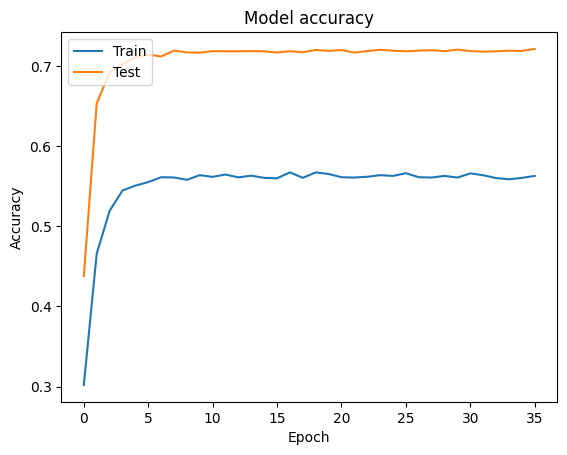

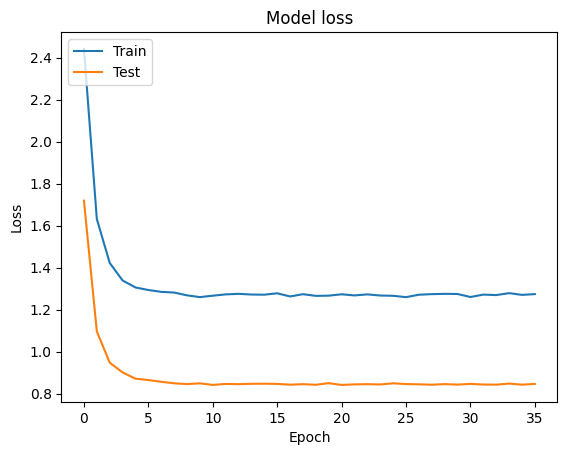

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# Calculate metrics using scikit-learn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
y_true = y_valid
y_pred = model.predict(x_enhanced_valid)
y_pred = np.argmax(y_pred, axis=1)
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

# Print out the results
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=train_generator.class_indices.keys()))

340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.7197
Precision: 0.7001
Recall: 0.7197
F1 Score: 0.6914

Classification Report:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.91      0.83      0.87       126
                                 Apple___Black_rot       0.72      0.59      0.65       124
                          Apple___Cedar_apple_rust       0.68      0.27      0.39        55
                                   Apple___healthy       0.79      1.00      0.88       329
                               Blueberry___healthy       0.93      1.00      0.96       300
          Cherry_(including_sour)___Powdery_mildew       0.56      0.68      0.61       210
                 Cherry_(including_sour)___healthy       0.57      0.16      0.25       170
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       1.00      0.52      0.68       102
                       Corn_(maize)___C

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### Residual Network

##### model 1

In [ ]:
input_soil = keras.Input(shape=(x_enhanced_valid.shape[1],), name='soil_input')

# Initial processing
x = layers.BatchNormalization()(input_soil)
x = layers.Dense(128, activation='relu')(x)

# Residual block 1
residual = x
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Add()([x, residual])  # Skip connection

# Residual block 2
residual = x
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Add()([x, residual])  # Skip connection

# Final layers
x = layers.Dense(64, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)

output = layers.Dense(train_generator.num_classes, activation='softmax')(x)

model = keras.Model(inputs=input_soil, outputs=output)

In [ ]:
#Advanced optimizer with learning rate scheduling
initial_learning_rate = 0.001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100,
    decay_rate=0.96,
    staircase=True
)

optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

# Compile model
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-7,
        verbose=1
    )
]

In [ ]:
# Train model
history = model.fit(
    x_enhanced_train, y_train,
    batch_size=32,
    epochs=200,
    validation_data=(x_enhanced_valid, y_valid),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/200
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.4641 - loss: 1.8691 - val_accuracy: 0.7456 - val_loss: 0.6943 - learning_rate: 5.8820e-04
Epoch 2/200
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6631 - loss: 0.9652 - val_accuracy: 0.7910 - val_loss: 0.5928 - learning_rate: 3.3214e-04
Epoch 3/200
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6924 - loss: 0.8668 - val_accuracy: 0.8007 - val_loss: 0.5494 - learning_rate: 1.9537e-04
Epoch 4/200
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7040 - loss: 0.8304 - val_accuracy: 0.8068 - val_loss: 0.5338 - learning_rate: 1.1032e-04
Epoch 5/200
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7064 - loss: 0.8015 - val_accuracy: 0.8051 - val_loss: 0.5233 - learning_rate: 6.4889e-05
Epoch 6/200
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7147 - loss: 0.7861 - val_accuracy: 0.8098 - val_loss: 0.5161 - learning_rate: 3.6641e-05
Epoch 7/200
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 5s

In [ ]:
# Evaluate the model
test_loss, test_acc = model.evaluate(x_enhanced_valid, y_valid, verbose=2)
print(f'\nTest accuracy: {test_acc}')

340/340 - 1s - 2ms/step - accuracy: 0.8123 - loss: 0.5086

Test accuracy: 0.8123329281806946


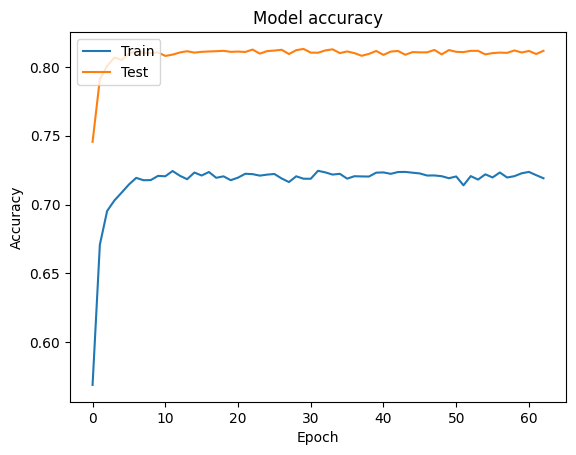

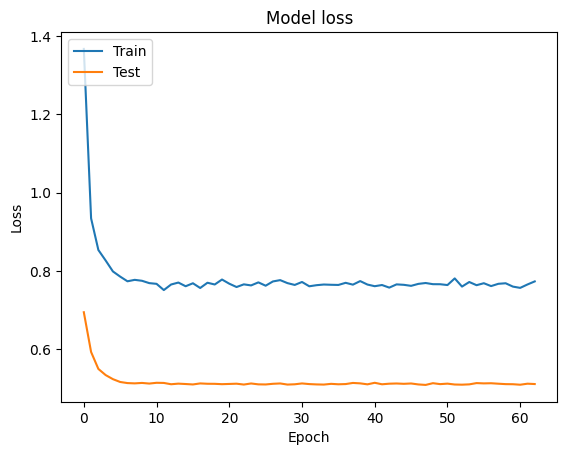

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# Calculate metrics using scikit-learn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
y_true = y_valid
y_pred = model.predict(x_enhanced_valid)
y_pred = np.argmax(y_pred, axis=1)
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

# Print out the results
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=train_generator.class_indices.keys()))

340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.8123
Precision: 0.8033
Recall: 0.8123
F1 Score: 0.7980

Classification Report:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.91      0.94      0.93       126
                                 Apple___Black_rot       0.82      0.90      0.86       124
                          Apple___Cedar_apple_rust       0.69      0.49      0.57        55
                                   Apple___healthy       1.00      1.00      1.00       329
                               Blueberry___healthy       0.98      1.00      0.99       300
          Cherry_(including_sour)___Powdery_mildew       0.80      0.96      0.87       210
                 Cherry_(including_sour)___healthy       0.85      0.86      0.86       170
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       1.00      0.87      0.93       102
                       Corn_(maize)___C

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
